- Why bother to learn about mixture models? 
- Why use them, what's the benefit of the extra effort to learn these techniques? 
- How can they be applied to trading?

In this chapter I'll set out to answer the aforementioned questions in a mostly show don't tell fashion. However before I can explain the significance of these techniques we have to cover some foundational material about time series prediction.

### Import modules and tools

In [1]:
%load_ext watermark
%watermark

# import standard libs

import sys
import os
import time

# import python scientific stack

import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import pandas_datareader.data as web
import numpy as np
import sklearn.mixture as mix
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as stats
import pymc3 as pm

# import visual tools

from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import plotnine as pn
import mizani.breaks as mzb
import mizani.formatters as mzf
import seaborn as sns

# import util libs
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

# set globals
"""['_classic_test', 'grayscale', 'seaborn-poster', 'seaborn-whitegrid', 'seaborn-muted', 'seaborn-white', 'fivethirtyeight', 'seaborn-bright', 'seaborn-paper', 'seaborn-dark', 'seaborn', 'seaborn-pastel', 'dark_background', 'seaborn-notebook', 'seaborn-deep', 'seaborn-dark-palette', 'ggplot', 'seaborn-ticks', 'bmh', 'seaborn-colorblind', 'classic', 'seaborn-darkgrid', 'seaborn-talk']"""
plt.style.use('seaborn-ticks')
plt.rcParams['font.family'] = 'DejaVu Sans Mono'
plt.rcParams['figure.figsize'] = 9,7

blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

RANDOM_STATE = 777
dfwaic = pd.DataFrame() # setup for WAIC evaluations

print()
%watermark -p pymc3,pandas,pandas_datareader,numpy,sklearn,statsmodels,scipy,matplotlib,seaborn,plotnine,pyarrow

2017-10-19T18:33:47-06:00

CPython 3.6.2
IPython 6.1.0

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.4.0-96-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


/media/files/anaconda3/envs/pymc3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools



pymc3 3.1
pandas 0.20.3
pandas_datareader 0.5.0
numpy 1.13.1
sklearn 0.19.0
statsmodels 0.8.0
scipy 0.19.1
matplotlib 2.0.2
seaborn 0.8.1
plotnine 0.2.1+13.g65bdce6
pyarrow 0.7.0


In [2]:
# some conv fns

def cprint(df):
    print('-'*79)
    print('dataframe information')
    print('-'*79)
    print(df.tail(5))
    print('-'*50)
    print(df.info())
    print('-'*79)    
    print()
    
get_range = lambda df, col: (df[col].min(), df[col].max())
get_pct_shape = lambda df, col: (df[col].nunique() / df[col].shape[0])

#### First let's get some market data from Yahoo. We'll get the adjusted closing price for multiple ETFs. 

In [3]:
get_price = lambda sym, start, end: web.DataReader(sym, 'yahoo', start, end)['Adj Close']

#f1 = 'TEDRATE' # ted spread
#f2 = 'T10Y2Y' # constant maturity ten yer - 2 year
#f3 = 'T10Y3M' # constant maturity 10yr - 3m
#factors = [f1, f2, f3]

chosen_syms = ['SPY', 'QQQ', 'TLT', 'GLD', 'EFA', 'EEM']

end = pd.to_datetime('2017-09-30')
start = end - 25 * 252 * pd.tseries.offsets.BDay()

#%time df = (pd.DataFrame({sym:get_price(sym, start, end) for sym in chosen_syms}).dropna())


next we create the return dataframe and save it using pyarrow. this dataset is small enough to save as csv or h5 but if you intend on dealing with larger datasets I recommend developing the pyarrow habit now.

In [4]:
#rs = np.log(df/df.shift(1)).dropna()
#cprint(rs)

In [5]:
save_parquet = lambda df, save_fp: pq.write_table(pa.Table.from_pandas(df), save_fp)

pdir = '/media/files/_Code/mixture_model_trading/'
#save_fp = pdir + f'data/etf_returns_{rs.index.min().date()}-{rs.index.max().date()}.parquet'
#save_parquet(rs, save_fp)

In [6]:
load_parquet = lambda fp: pq.read_table(fp)

load_fp = pdir+'data/etf_returns_2004-11-19-2017-09-29.parquet'
rs = (load_parquet(load_fp).to_pandas())
cprint(rs)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
               EEM     EFA     GLD     QQQ     SPY     TLT
Date                                                      
2017-09-25 -0.0171 -0.0057  0.0104 -0.0106 -0.0020  0.0062
2017-09-26 -0.0027 -0.0022 -0.0112  0.0026  0.0006 -0.0018
2017-09-27 -0.0036  0.0007 -0.0095  0.0090  0.0039 -0.0152
2017-09-28 -0.0007  0.0026  0.0019 -0.0003  0.0012 -0.0030
2017-09-29  0.0114  0.0059 -0.0052  0.0072  0.0035  0.0022
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3238 entries, 2004-11-19 to 2017-09-29
Data columns (total 6 columns):
EEM    3238 non-null float64
EFA    3238 non-null float64
GLD    3238 non-null float64
QQQ    3238 non-null float64
SPY    3238 non-null float64
TLT    3238 non-null float64
dtypes: float64(6)
memory usage: 177.1 KB
None
---------

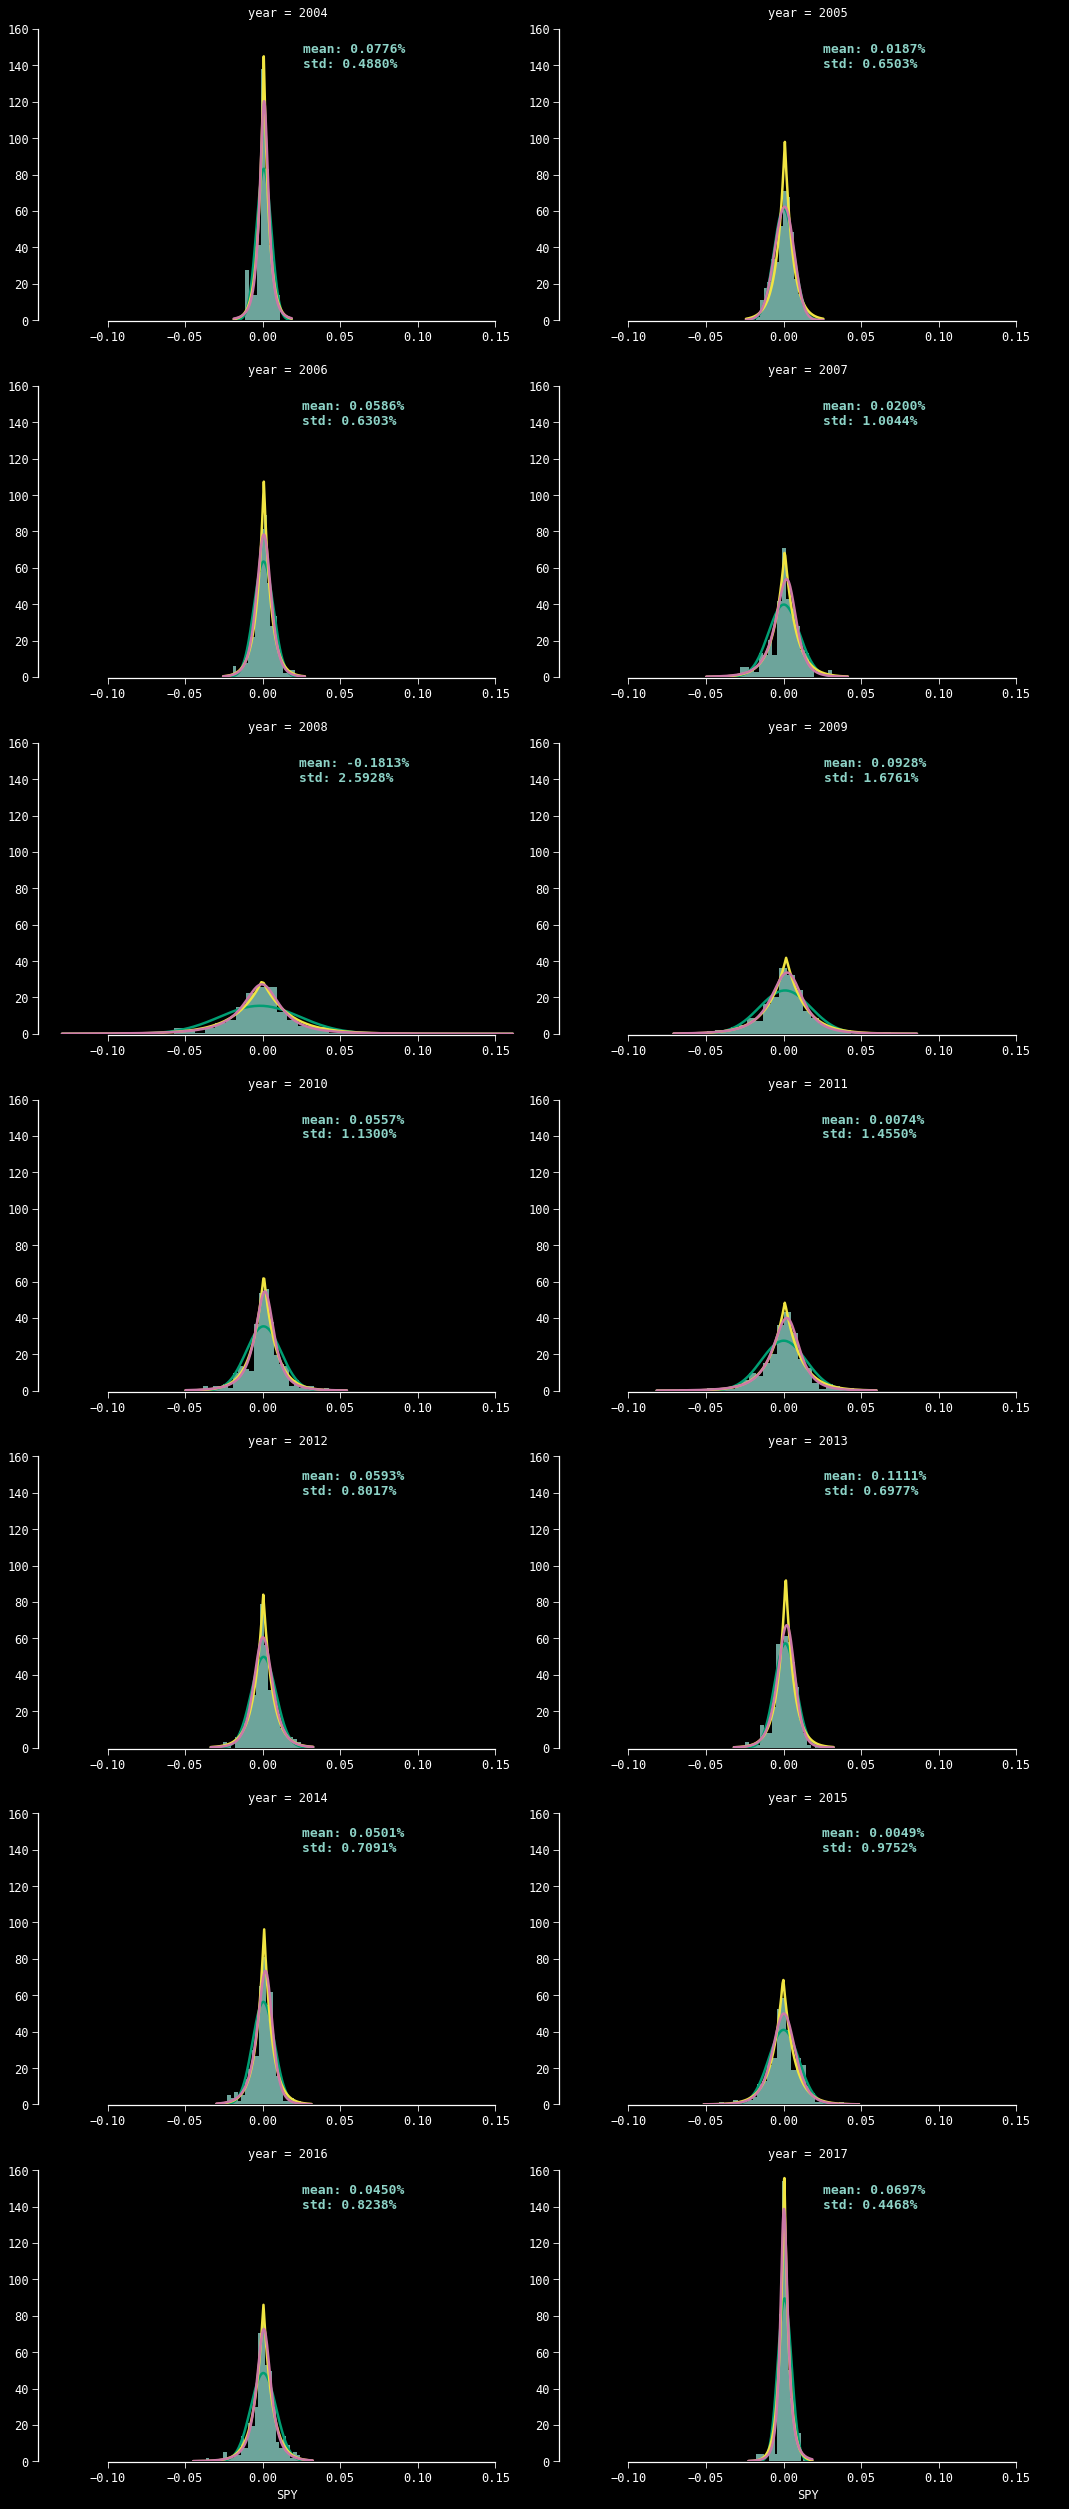

In [38]:
def vertical_mean_line2(x, **kwargs):
    ls = {"0":"-","1":"--"}
    #alpha5, alpha95 = pm.hpd(x)
    mean, std = x.mean(), x.std()
    
    #plt.axvline(mean, linestyle =ls[kwargs.get("label","0")], 
    #            color = kwargs.get("color", "g"))
    txkw = dict(size=13, fontweight='demi', color=kwargs.get("color", "g"), rotation=0)

    mean_tx = "mean: {:.4%}".format(mean)
    std_tx = "std: {:.4%}".format(std)
    
    ymin, ymax = plt.gca().get_ylim()
    plt.text(mean+0.025, 0.9*ymax, mean_tx, **txkw)
    plt.text(mean+0.025, 0.85*ymax, std_tx, **txkw) 
    
"""['_classic_test', 'grayscale', 'seaborn-poster', 'seaborn-whitegrid', 'seaborn-muted', 'seaborn-white', 'fivethirtyeight', 'seaborn-bright', 'seaborn-paper', 'seaborn-dark', 'seaborn', 'seaborn-pastel', 'dark_background', 'seaborn-notebook', 'seaborn-deep', 'seaborn-dark-palette', 'ggplot', 'seaborn-ticks', 'bmh', 'seaborn-colorblind', 'classic', 'seaborn-darkgrid', 'seaborn-talk']"""

def plot_facet_hist(rs, ex):
    plt.style.use('dark_background')

    #ex = rs.SPY
    plt.rcParams['font.size'] = 12
    g = (rs.assign(year=lambda df: df.index.year)
         .pipe(sns.FacetGrid, 
               col='year',
               col_wrap=2,
               size=5,
               aspect=1.5)
         .map(sns.distplot, ex.name, kde=False, fit=stats.norm, fit_kws={'color':green, 'lw':2.5})
         .map(sns.distplot, ex.name, kde=False, fit=stats.laplace, fit_kws={'linestyle':'-', 'color':gold, 'lw':2.5})
         .map(sns.distplot, ex.name, kde=False, fit=stats.johnsonsu,fit_kws={'linestyle':'-', 'color':purple, 'lw':2.5})
         .map(vertical_mean_line2, ex.name)
         .fig.subplots_adjust(hspace=.20))
    #g.ax.axvline(ex.median(), color=red, ls='--')
    sns.despine(offset=1, trim=True);
    
plot_facet_hist(rs, rs.SPY)    

Now let's look at a canonical example of a return distribution using the SPY etf. 

In [40]:
def vertical_mean_line2(x, **kwargs):
    ls = {"0":"-","1":"--"}
    #alpha5, alpha95 = pm.hpd(x)
    mean = x.mean()
    plt.axvline(mean, linestyle =ls[kwargs.get("label","0")], 
                color = kwargs.get("color", "g"))
    txkw = dict(size=12, color = kwargs.get("color", "g"), rotation=90)

    tx = f"mean: {mean:.4f}"
    ymin, ymax = plt.gca().get_ylim()
    plt.text(mean+0.01, 0.9*ymax, tx, **txkw)   

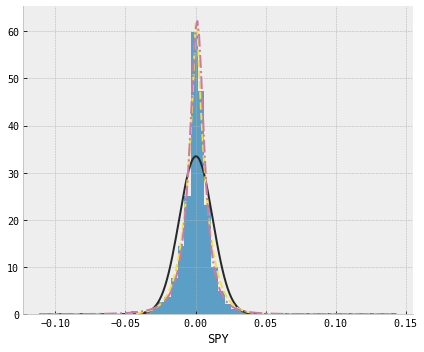

In [139]:
ex = rs.SPY

g = (rs
     .pipe(sns.FacetGrid, 
           size=5,
           aspect=1.2)
     .map(sns.distplot, ex.name, kde=False, fit=stats.norm)
     .map(sns.distplot, ex.name, kde=False, fit=stats.laplace, fit_kws={'linestyle':'--', 'color':gold})
     .map(sns.distplot, ex.name, kde=False, fit=stats.johnsonsu,fit_kws={'linestyle':'-.', 'color':purple}))
     #.map(vertical_mean_line2, ex.name))

In [85]:
norm = stats.norm

def generate_norm_rvs(ser):
    N = ser.shape[0]
    _min, _max = ser.min(), ser.max()
    x = np.linspace(_min, _max, N)
    
    y = norm(ser.mean(), ser.std()).pdf(x)
    return x, y

def generate_norm_cdf(ser):
    N = ser.shape[0]
    _min, _max = ser.min(), ser.max()
    x = np.linspace(_min, _max, N)
    
    y = norm.cdf(x, ser.mean(), ser.std())
    return x, y

#x, y = generate_norm_pdf(ex)
x, y = generate_norm_cdf(ex)

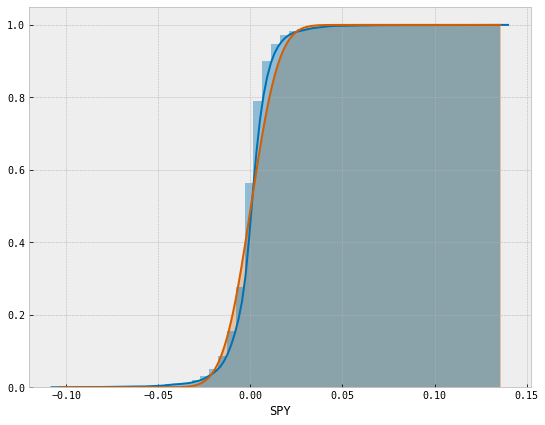

In [98]:
g = sns.distplot(ex, hist_kws={'cumulative':True}, kde_kws={'cumulative':True}, color=blue)
g.plot(x, y, color=red)
g.fill_between(x, 0, y, color=red, alpha=0.3)

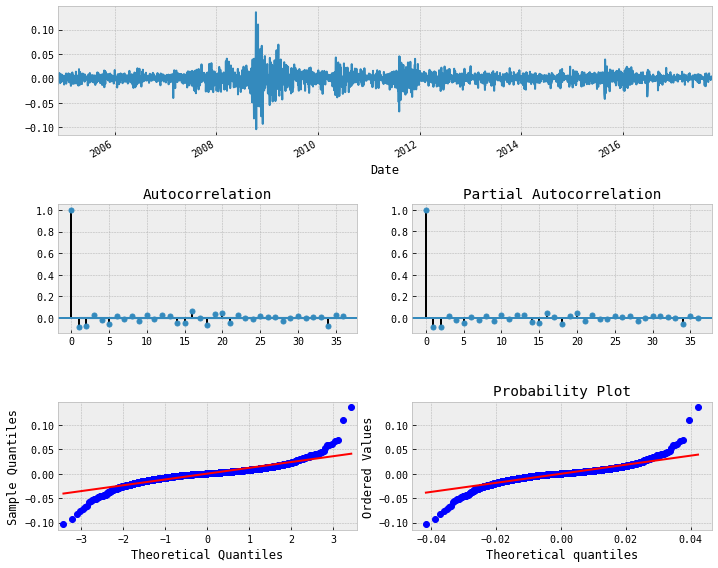

In [126]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        stats.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        #acf_arr = smt.acf(y, nlags=lags)
        #pacf_arr = smt.pacf(y, nlags=lags)
        #[ax.set_xlim(1.5) for ax in [acf_ax, pacf_ax]]
        #[ax.set_yscale('log') for ax in [acf_ax, pacf_ax]]
        
        #[ax.set_ylim([min(acf_arr), max(acf_arr)]) for ax in [acf_ax]]
        #[ax.set_ylim([min(pacf_arr), max(pacf_arr)]) for ax in [pacf_ax]]
        #sns.despine()
        plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

_ = tsplot(ex, lags=36)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f940785a940>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9407460be0>)

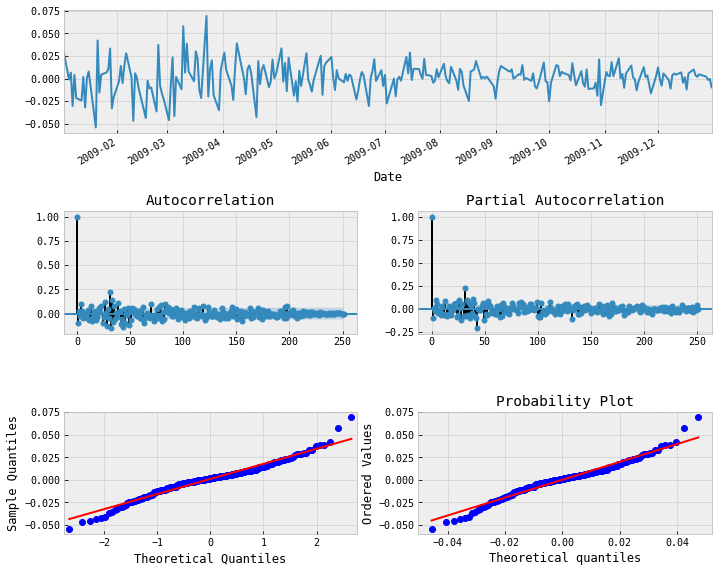

In [127]:
tsplot(rs.SPY.loc['2009'])

(<matplotlib.axes._subplots.AxesSubplot at 0x7f94076a0470>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f940747c320>)

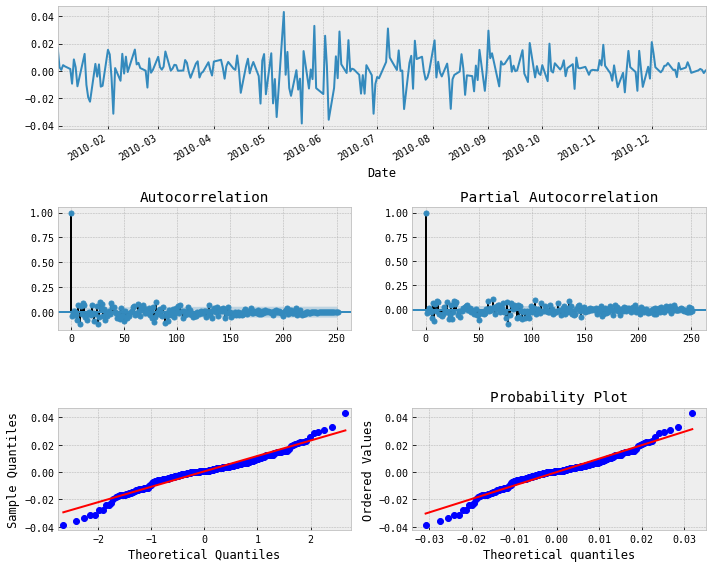

In [128]:
tsplot(rs.SPY.loc['2010'])